In [ ]:
!pip uninstall tensorflow
!pip install tensorflow

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.15.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
Y
  Successfully uninstalled tensorflow-2.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 31.5 MB/s eta 0:00:00
  Attempting uninstall: ml-

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.convnext import preprocess_input
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from keras.regularizers import l2
from sklearn.metrics import f1_score,confusion_matrix
from keras.utils import to_categorical
import os
from PIL import Image
import zipfile
import random
import warnings
warnings.filterwarnings("ignore")

loading data and labeling them

In [ ]:
!gdown --id 15CHt2ueS4c7emHpmzFHC3c0TGd51Mnvz

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=15CHt2ueS4c7emHpmzFHC3c0TGd51Mnvz
From (redirected): https://drive.google.com/uc?id=15CHt2ueS4c7emHpmzFHC3c0TGd51Mnvz&confirm=t&uuid=0711baba-a971-4e5e-99a6-f7b5ce2bb44e
To: /content/train.zip
100% 898M/898M [00:12<00:00, 72.6MB/s]


In [ ]:
with zipfile.ZipFile('train.zip', 'r') as zip_ref:
    zip_ref.extractall('train')

In [2]:
main_directory = '/content/train/train'

train_data = []
label_data = []

for folder_name in os.listdir(main_directory):
    folder_path = os.path.join(main_directory, folder_name)

    if os.path.isdir(folder_path):
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)

            if image_path.lower().endswith('.jpg'):
                try:
                    image = Image.open(image_path)
                    image = image.resize((128, 128))
                    image_array = np.array(image)
                    image_array = preprocess_input(image_array)


                    train_data.append(image_array)
                    label_data.append(folder_name)
                except Exception as e:
                    print(f"Error loading image {image_path}: {e}")

Error loading image /content/train/train/chicken/6fcf7983-225.jpg: cannot identify image file '/content/train/train/chicken/6fcf7983-225.jpg'
Error loading image /content/train/train/chicken/2a2a3166-2d2.jpg: cannot identify image file '/content/train/train/chicken/2a2a3166-2d2.jpg'
Error loading image /content/train/train/chicken/e5574159-a60.jpg: cannot identify image file '/content/train/train/chicken/e5574159-a60.jpg'
Error loading image /content/train/train/chicken/052f1133-141.jpg: cannot identify image file '/content/train/train/chicken/052f1133-141.jpg'
Error loading image /content/train/train/chicken/1b4ed8be-285.jpg: cannot identify image file '/content/train/train/chicken/1b4ed8be-285.jpg'


In [3]:
train_data = np.array(train_data)
print(f"Loaded {len(train_data)} images with corresponding {len(label_data)} labels.")

Loaded 24084 images with corresponding 24084 labels.


visulize some data

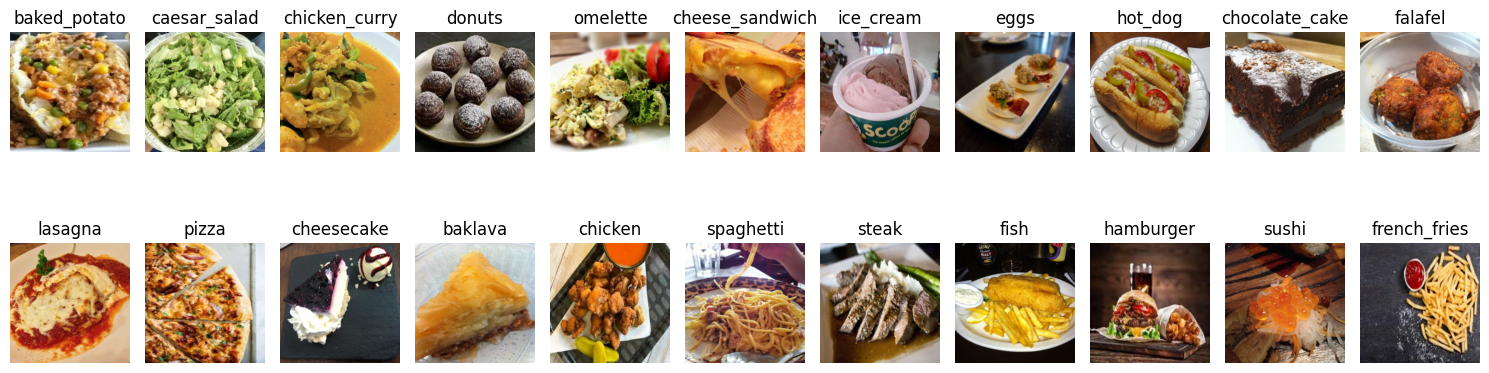

In [ ]:
unique_classes = set(label_data)

images_by_class = {class_name: [] for class_name in unique_classes}

for image, label in zip(train_data, label_data):
    images_by_class[label].append(image)

num_classes_to_display = len(unique_classes)

plt.figure(figsize=(15, 5))
for i, class_name in enumerate(unique_classes):
    random_image = random.choice(images_by_class[class_name])

    plt.subplot(2, num_classes_to_display // 2, i + 1)
    plt.imshow(random_image.astype('uint8'))
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

data generators

In [4]:
label_mapping = {
    "steak": 0,
    "fish": 1,
    "baklava": 2,
    "chocolate_cake": 3,
    "chicken_curry": 4,
    "cheesecake": 5,
    "ice_cream": 6,
    "baked_potato": 7,
    "hamburger": 8,
    "sushi": 9,
    "omelette": 10,
    "pizza": 11,
    "chicken": 12,
    "cheese_sandwich": 13,
    "french_fries": 14,
    "falafel": 15,
    "donuts": 16,
    "lasagna": 17,
    "eggs": 18,
    "hot_dog": 19,
    "spaghetti": 20,
    "caesar_salad": 21,
}

In [5]:
train_labels_enc = np.array([label_mapping[label] for label in label_data])

In [6]:
y_one_hot = to_categorical(train_labels_enc, num_classes=22)

In [7]:
np.save('train_data.npy', train_data)
np.save('label_data.npy', y_one_hot)

In [5]:
data = np.load('/content/train_data.npy')
label = np.load('/content/label_data.npy')

In [6]:
X_train, X_val, y_train, y_val = train_test_split(data, label, test_size=0.2, random_state=42)

In [7]:
datagen = ImageDataGenerator(
    horizontal_flip=True
)

In [8]:
train_generator = datagen.flow(
    X_train,
    y_train,
    batch_size=16,
    shuffle=True
)

validation_generator = datagen.flow(
    X_val,
    y_val,
    batch_size=16,
    shuffle=False
)

model first try

In [9]:
model = keras.applications.ConvNeXtSmall(input_shape=X_train.shape[1:], classes=22, weights="imagenet", include_top=False)

for layer in model.layers:
    layer.trainable = False

conv = keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3))(model.output)
pool = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv)
flatten = keras.layers.Flatten()(pool)
dense = keras.layers.Dense(units=22, activation='softmax',kernel_regularizer=l2(1e-3))(flatten)
model_C = keras.models.Model(model.input, dense)
model_C.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 convnext_small_prestem_nor  (None, 128, 128, 3)          0         ['input_1[0][0]']             
 malization (Normalization)                                                                       
                                                                                                  
 convnext_small_stem (Seque  (None, 32, 32, 96)           4896      ['convnext_small_prestem_norma
 ntial)                                                             lization[0][0]']              
                                                                                              

In [10]:
model_C.compile(loss ='categorical_crossentropy',
              optimizer = keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1e-3),
              metrics = ['accuracy'])

In [11]:
lr_pl=ReduceLROnPlateau(monitor="val_accuracy",
                        patience=3,
                        min_delta=0.01,
                        factor=0.048)

In [12]:
history = model_C.fit(X_train,
                      y_train,
                      validation_data=[X_val, y_val],
                      batch_size=8,
                      epochs=15,
                      callbacks=[lr_pl])

Epoch 1/15
2409/2409 [==============================] - 229s 85ms/step - loss: 1.2606 - accuracy: 0.6786 - val_loss: 1.0658 - val_accuracy: 0.7154 - lr: 0.0010
Epoch 2/15
2409/2409 [==============================] - 200s 83ms/step - loss: 0.7963 - accuracy: 0.7890 - val_loss: 1.0158 - val_accuracy: 0.7598 - lr: 0.0010
Epoch 3/15
2409/2409 [==============================] - 195s 81ms/step - loss: 0.5921 - accuracy: 0.8439 - val_loss: 0.9405 - val_accuracy: 0.7816 - lr: 0.0010
Epoch 4/15
2409/2409 [==============================] - 190s 79ms/step - loss: 0.4764 - accuracy: 0.8726 - val_loss: 1.0792 - val_accuracy: 0.7799 - lr: 0.0010
Epoch 5/15
2409/2409 [==============================] - 195s 81ms/step - loss: 0.3912 - accuracy: 0.8975 - val_loss: 0.9886 - val_accuracy: 0.7953 - lr: 0.0010
Epoch 6/15
2409/2409 [==============================] - 196s 81ms/step - loss: 0.3253 - accuracy: 0.9175 - val_loss: 1.0394 - val_accuracy: 0.8030 - lr: 0.0010
Epoch 7/15
2409/2409 [==================

visualize loss and accuracy per epocks

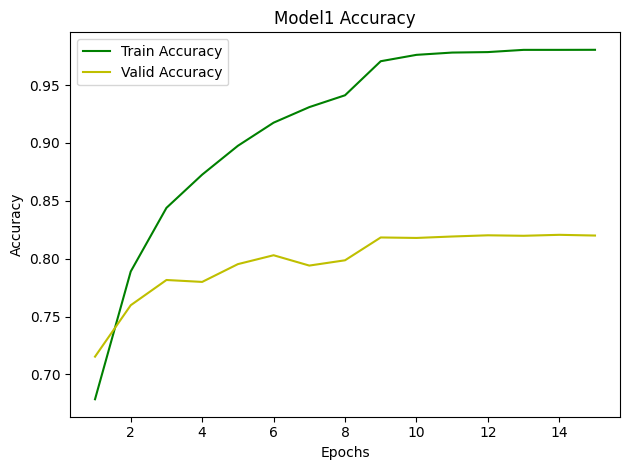

In [14]:
tr_acc1 = history.history['accuracy']
val_acc1 = history.history['val_accuracy']

epochs1 = [i+1 for i in range(len(tr_acc1))]

plt.plot(epochs1, tr_acc1, 'g', label='Train Accuracy')
plt.plot(epochs1, val_acc1, 'y', label='Valid Accuracy')
plt.title('Model1 Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

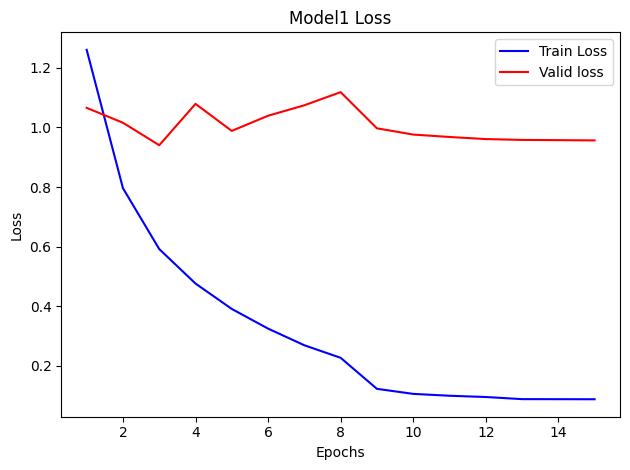

In [16]:
tr_loss1 = history.history['loss']
val_loss1 = history.history['val_loss']

epochs1 = [i+1 for i in range(len(tr_acc1))]

plt.plot(epochs1, tr_loss1, 'b', label='Train Loss')
plt.plot(epochs1, val_loss1, 'r', label='Valid loss')
plt.title('Model1 Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

saving model

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
C1 = model_C.to_json()

In [21]:
with open("/content/drive/MyDrive/ConvNeXtsmall_1.json",'w') as json_file:
  json_file.write(C1)

In [22]:
model_C.save_weights("/content/drive/MyDrive/ConvNeXtsmall_1.h5")

model secound try

In [24]:
history2 = model_C.fit(train_generator,
                      validation_data = validation_generator,
                      batch_size=16,
                      epochs=15,
                      callbacks=[lr_pl])

Epoch 1/15
1205/1205 [==============================] - 154s 128ms/step - loss: 0.3034 - accuracy: 0.9296 - val_loss: 0.9461 - val_accuracy: 0.8198 - lr: 2.5480e-10
Epoch 2/15
1205/1205 [==============================] - 138s 114ms/step - loss: 0.3091 - accuracy: 0.9279 - val_loss: 0.9581 - val_accuracy: 0.8173 - lr: 2.5480e-10
Epoch 3/15
1205/1205 [==============================] - 140s 116ms/step - loss: 0.3010 - accuracy: 0.9289 - val_loss: 0.9524 - val_accuracy: 0.8206 - lr: 2.5480e-10
Epoch 4/15
1205/1205 [==============================] - 140s 116ms/step - loss: 0.3045 - accuracy: 0.9294 - val_loss: 0.9296 - val_accuracy: 0.8192 - lr: 2.5480e-10
Epoch 5/15
1205/1205 [==============================] - 139s 116ms/step - loss: 0.3118 - accuracy: 0.9280 - val_loss: 0.9345 - val_accuracy: 0.8217 - lr: 1.2231e-11
Epoch 6/15
1205/1205 [==============================] - 138s 115ms/step - loss: 0.3164 - accuracy: 0.9278 - val_loss: 0.9589 - val_accuracy: 0.8206 - lr: 1.2231e-11
Epoch 7/15

visualize loss and accuracy per epocks

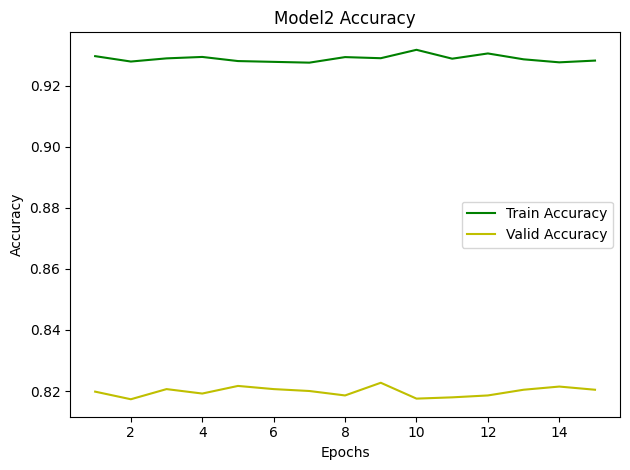

In [25]:
tr_acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

epochs2 = [i+1 for i in range(len(tr_acc2))]

plt.plot(epochs2, tr_acc2, 'g', label='Train Accuracy')
plt.plot(epochs2, val_acc2, 'y', label='Valid Accuracy')
plt.title('Model2 Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

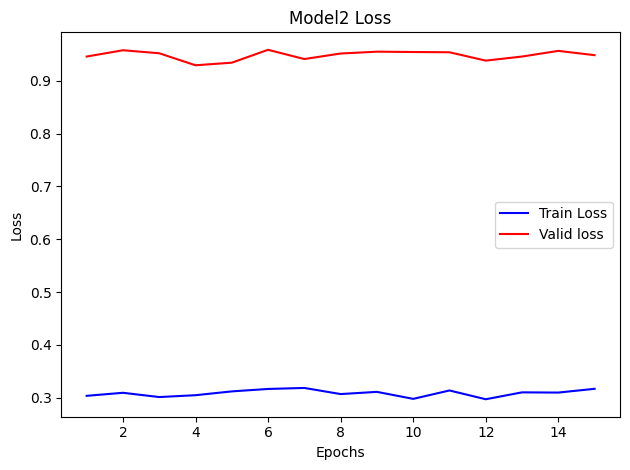

In [26]:
tr_loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs2 = [i+1 for i in range(len(tr_acc2))]

plt.plot(epochs2, tr_loss2, 'b', label='Train Loss')
plt.plot(epochs2, val_loss2, 'r', label='Valid loss')
plt.title('Model2 Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [27]:
C2 = model_C.to_json()

In [28]:
with open("/content/drive/MyDrive/ConvNeXtsmall_2.json",'w') as json_file:
  json_file.write(C2)

In [29]:
model_C.save_weights("/content/drive/MyDrive/ConvNeXtsmall_2.h5")

test data

In [ ]:
# test_datagenerator = ImageDataGenerator()


# test_generator=test_datagenerator.flow_from_directory(
#     "/content/drive/MyDrive/test",
#     target_size=(224,224),
#     shuffle=False,
#     batch_size=1,
#     class_mode=None
# )

loading model

In [ ]:
# model_cnxl.load_weights('/content/drive/MyDrive/ConvNeXtLarge_1.h5')

In [ ]:
# y_pred=model_cnxl.predict(test_generator)

In [ ]:
# name=test_generator.filenames
# label=np.argmax(y_pred,axis=1)+1

In [ ]:
# t=pd.DataFrame({'name':name,'predicted':label})
# t.to_csv('finall.csv')